In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Excessive-invariance')
sys.path.append(str(base))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/Excessive-invariance")
os.listdir()

['Test.ipynb',
 'autoencoder.pth',
 'semantic_classifier.pth',
 'img.jpg',
 'data',
 '__pycache__',
 'utils.py',
 'autoencoder.ipynb']

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable, Function
from copy import deepcopy
from itertools import chain
import math
import pandas as pd
from PIL import Image

from utils import *

In [4]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

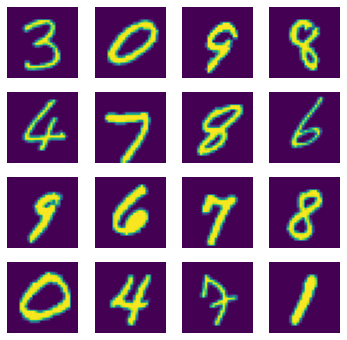

In [ ]:
fig = plt.figure(figsize=(6,6))
for i in range(16):
  index = np.random.randint(len(train_data))
  img, label = train_data[index]
  fig.add_subplot(4, 4, i+1)
#  plt.title('label: {}'.format(label))
  plt.axis('off')
  plt.imshow(torch.reshape(img, (28,28)))

### Find learning rate

In [ ]:
# не используется

def find_lr(model, dataloader, optimizer, init_value = 1e-8, final_value=10., beta = 0.98):
    #based on https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

    num = len(dataloader.dataset)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs,labels in dataloader:
        batch_num += 1
      #  print(inputs.size())
        inputs = inputs.view(inputs.shape[0], -1)
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        logits = autoencoder.encoder(inputs)
        semantic = logits[:, :10]
        outputs = model(semantic)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [ ]:
model_lr = nn.Sequential(nn.Linear(10,32),nn.ReLU(), nn.Linear(32,10)).to(device)
optimizer = torch.optim.SGD(model_lr.parameters(), lr=1e-3)

In [ ]:
logs,losses = find_lr(model_lr, train_loader, optimizer)
plt.xlabel('loss')
plt.ylabel('learning rate')
plt.xscale('log')
plt.plot(logs[10:-5],losses[10:-5]);

###Train autoencoder

In [6]:
class Autoencoder(nn.Module):
  def __init__(self, input_size=28*28):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 64),
        nn.LeakyReLU())
    self.decoder = nn.Sequential(
        nn.Linear(64, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, input_size),   
        nn.Sigmoid())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [ ]:
autoencoder, loss_history_ae = train_autoencoder(model, criterion, optimiser, train_loader, num_epochs)

epoch [1/10], loss:0.0281

epoch [2/10], loss:0.0208

epoch [3/10], loss:0.0166

epoch [4/10], loss:0.0181

epoch [5/10], loss:0.0177

epoch [6/10], loss:0.0128

epoch [7/10], loss:0.0151

epoch [8/10], loss:0.0144

epoch [9/10], loss:0.0119

epoch [10/10], loss:0.0106



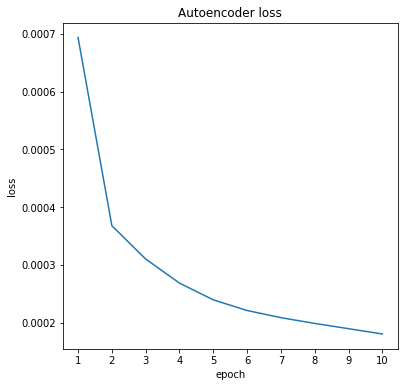

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(autoencoder.state_dict(), "autoencoder.pth")


In [7]:
# download pretrained model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder.pth'))
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in

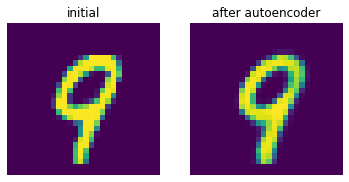

In [ ]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

###Train classifier

In [8]:
class Classifier(nn.Module):
    def __init__(self, input_size=10):
      super(Classifier, self).__init__()
      self.classifier = nn.Sequential(
          nn.Linear(10,32),
          nn.ReLU(),
          nn.Linear(32,10))
    
    def forward(self, x):
      # predict by semantic logits - size 10
      x = self.classifier(x)
      return x
    
    def predict_by_image(self, img, autoencoder):
      # input is (28, 28) or (1, 28, 28) tensor
      img = torch.reshape(img, (1, 28*28))
      semantic = autoencoder.encoder(img)[:,:10]
      output = self.classifier(semantic)
      _, preds = torch.max(output, 1)
      return preds.item()


In [ ]:
model = Classifier().to(device)
#model = nn.Sequential(nn.Linear(10,10), nn.ReLU(), nn.Linear(10,10)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 10

In [ ]:
classifier, loss_history, acc_history = train_classifier(model, autoencoder, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

train epoch [1/10], loss: 0.9251, acc: 0.6797
val epoch [1/10], loss: 0.7477, acc: 0.7392

train epoch [2/10], loss: 0.6602, acc: 0.7720
val epoch [2/10], loss: 0.5881, acc: 0.8013

train epoch [3/10], loss: 0.5657, acc: 0.8053
val epoch [3/10], loss: 0.5735, acc: 0.8075

train epoch [4/10], loss: 0.5185, acc: 0.8229
val epoch [4/10], loss: 0.4980, acc: 0.8352

train epoch [5/10], loss: 0.4876, acc: 0.8343
val epoch [5/10], loss: 0.4657, acc: 0.8480

val epoch [6/10], loss: 0.4490, acc: 0.8571

train epoch [7/10], loss: 0.4429, acc: 0.8521
val epoch [7/10], loss: 0.4367, acc: 0.8609

train epoch [8/10], loss: 0.4267, acc: 0.8585
val epoch [8/10], loss: 0.4211, acc: 0.8691

train epoch [9/10], loss: 0.4179, acc: 0.8608
val epoch [9/10], loss: 0.4141, acc: 0.8660

train epoch [10/10], loss: 0.4052, acc: 0.8659
val epoch [10/10], loss: 0.4054, acc: 0.8717



In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(classifier.state_dict(), "semantic_classifier.pth")

In [9]:
#download pretrained model
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('semantic_classifier.pth'))
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

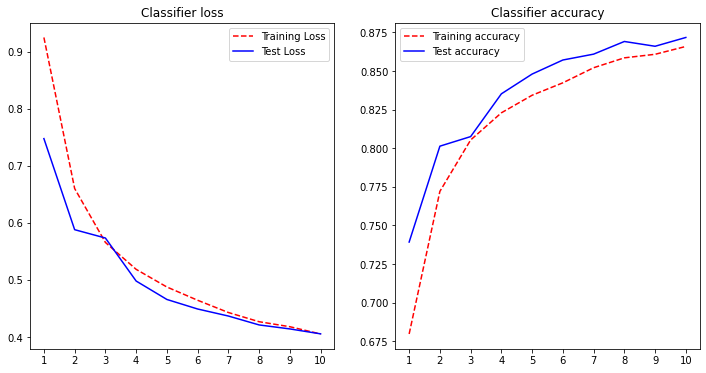

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Classifier loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Classifier accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

### Build full model with domain adaptation loss

---



In [11]:
class Reversal_layer(Function):
  @staticmethod
  def forward(self, x):
    return x
  
  @staticmethod
  def backward(self, grad):
    return grad.neg()

In [12]:
class Full_model(nn.Module):
  def __init__(self):
      super(Full_model, self).__init__()
      self.autoencoder = Autoencoder()

      self.semantic_classifier = Classifier()

      self.nuisance_classifier = nn.Sequential(
          nn.Linear(54, 32),
          nn.ReLU(),
          nn.Linear(32, 10))
      
  def forward(self, img):
      logits = self.autoencoder.encoder(img)
      semantic = logits[:, :10]
      nuisance = logits[:, 10:]
      nuisance = Reversal_layer.apply(nuisance)
      class_output = self.semantic_classifier(semantic)
      domain_output = self.nuisance_classifier(nuisance)

      return class_output, domain_output


In [32]:
def train_full_model(model, oprimizer, class_criterion, domain_criterion, dataloaders, num_epochs):

  loss_history = {'train': [], 'val': []}
  acc_history = {'train': [], 'val': []}

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        epoch_class_loss = 0.
        epoch_domain_loss = 0.
        running_correct = 0
        running_loss = 0.

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.view(inputs.shape[0], -1)
            inputs = Variable(inputs.to(device))
            class_labels = Variable(labels.to(device))

            #make domain binary labels
            domain_labels = torch.zeros((len(inputs), 10)).float()
            for i in range(len(labels.data)):
                domain_labels.data[i][labels.data[i]] = 1.
            domain_labels = Variable(domain_labels.to(device))

            optimizer.zero_grad()

            class_output, domain_output = model(inputs)
            _, class_preds = torch.max(class_output, 1)
            class_loss = class_criterion(class_output, class_labels)
            running_correct += torch.sum(class_labels == class_preds.data)          

            domain_loss = domain_criterion(domain_output, domain_labels)

          #  epoch_class_loss += class_loss
          #  epoch_domain_loss += domain_loss
            loss = class_loss - domain_loss
            running_loss += loss * inputs.size(0)
            if phase == 'train':
                loss.backward()
                optimizer.step()

        epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        acc_history[phase].append(epoch_acc)
        loss_history[phase].append(epoch_loss)
            
        print('{} epoch [{}/{}], class acc: {:.4f}, loss: {:.4f}'.format(
                  phase, epoch+1, num_epochs, epoch_acc, epoch_loss))
    
  return model, acc_history, loss_history


In [33]:
model = Full_model()
model.autoencoder = autoencoder

params_to_update = chain(model.semantic_classifier.parameters(),model.nuisance_classifier.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=1e-2)

num_epochs = 10

In [36]:
full_model, acc_history, loss_history = train_full_model(model, optimizer, nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss(), dataloaders, num_epochs)

train epoch [1/10], class acc: 0.8156, loss: -2534866.0000
val epoch [1/10], class acc: 0.8274, loss: -3259148.0000
train epoch [2/10], class acc: 0.8321, loss: -4057291.0000
val epoch [2/10], class acc: 0.8432, loss: -4928241.5000
train epoch [3/10], class acc: 0.8425, loss: -5857344.0000
val epoch [3/10], class acc: 0.8466, loss: -6867680.5000
train epoch [4/10], class acc: 0.8489, loss: -7920910.0000
val epoch [4/10], class acc: 0.8588, loss: -9066248.0000
train epoch [5/10], class acc: 0.8569, loss: -10239032.0000
val epoch [5/10], class acc: 0.8549, loss: -11517367.0000
train epoch [6/10], class acc: 0.8605, loss: -12808386.0000
val epoch [6/10], class acc: 0.8575, loss: -14219836.0000
train epoch [7/10], class acc: 0.8654, loss: -15626934.0000
val epoch [7/10], class acc: 0.8534, loss: -17171246.0000
train epoch [8/10], class acc: 0.8691, loss: -18691332.0000
val epoch [8/10], class acc: 0.8694, loss: -20366494.0000
train epoch [9/10], class acc: 0.8721, loss: -22000834.0000
val 

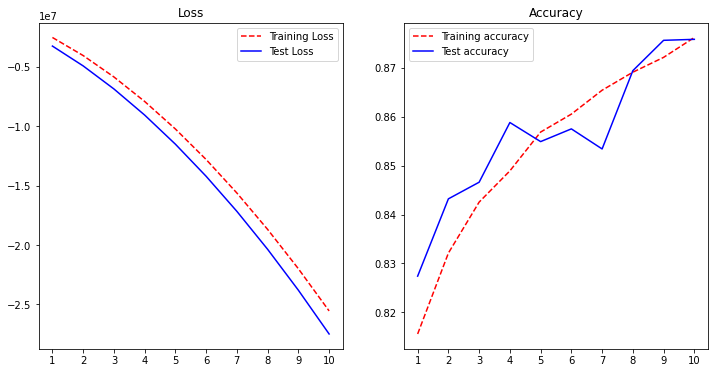

In [37]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);


### Attack it

In [38]:
def attack(encoder, classifier, input, target, num_iter, alpha, collect_data=False):
  with torch.set_grad_enabled(True):
    input = torch.reshape(input, (1, 28*28))
    target = torch.reshape(target, (1, 28*28))

    first_flip = -1   # when label changes to target label fot the first time
    init_label = classifier.predict_by_image(input, autoencoder)
    target_label = classifier.predict_by_image(target, autoencoder)
    output_targ = encoder(target)[:, :10]
    best_loss = 10000.
    if collect_data:
        labels_results = pd.DataFrame(columns=['input', 'target', 'current', 'iteration', 'jpeg'])
    else:
        labels_results = None

    img = deepcopy(input)
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True)

    for i in range(num_iter):
      output = encoder(img)[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      #gradien descent step
      img.data -= alpha * torch.sign(img.grad.data)

      curr_label = classifier.predict_by_image(img, autoencoder)
      if curr_label == target_label and first_flip == -1:
        first_flip = i

      # testing jpeg and collecting results
      if collect_data:
        if first_flip != -1:    # attack was made
          img_jpeg = to_jpg_and_back(img)
          jpeg_label = classifier.predict_by_image(img_jpeg, autoencoder)
          labels_results = labels_results.append({'input': init_label,
                                 'target': target_label,
                                 'current': curr_label,
                                 'iteration': i,
                                 'jpeg': jpeg_label},
                                ignore_index=True)

  return best_img, best_loss, first_flip, labels_results

full model prediction:  6
classifier prediction:  6


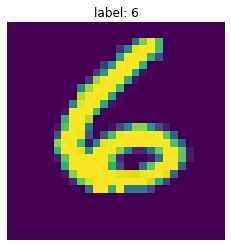

In [53]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
plt.title('label: {}'.format(label1))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

print("full model prediction: ", full_model.semantic_classifier.predict_by_image(img1, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(img1, autoencoder))

full model prediction:  5
classifier prediction:  5


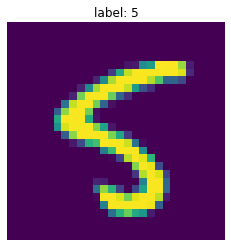

In [49]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
plt.title('label: {}'.format(label2))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

print("full model prediction: ", full_model.semantic_classifier.predict_by_image(img2, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(img2, autoencoder))

with domain adaptation:  4
no domain adaptation: label 5, flip iter: 49


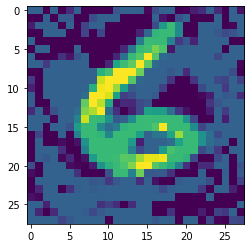

In [57]:
adv, _, flip, df = attack(autoencoder.encoder, classifier, img1, img2, 60, 1./255, True)

plt.imshow(torch.reshape(adv, (28, 28)).detach());
print("with domain adaptation: ", full_model.semantic_classifier.predict_by_image(adv, full_model.autoencoder))
print("no domain adaptation: label {}, flip iter: {}".format(classifier.predict_by_image(adv, autoencoder), flip))

In [62]:
df

,input,target,current,iteration,jpeg
0,6,5,5,49,8
1,6,5,5,50,8
2,6,5,5,51,8
3,6,5,5,52,8
4,6,5,5,53,8
5,6,5,5,54,8
6,6,5,5,55,8
7,6,5,5,56,8
8,6,5,5,57,8
9,6,5,5,58,8


### JPEG convertation

In [56]:
def to_jpg_and_back(img):
  img = torch.reshape(img, (28, 28))
  img = img.data.cpu().numpy()

  #make jpg
  img = img * 255.0
  img = np.clip(img, 0, 255).astype(np.uint8)
  img_pil = torchvision.transforms.ToPILImage()(img)
  img_pil.save('img.jpg', 'JPEG')

  #back to tensor
  img_back = (np.asarray(Image.open('img.jpg')) / 255.0).astype(np.float32)
  transform = transforms.ToTensor()
  img_back = transform(img_back)
  img_back = torch.reshape(img_back, (1, 28, 28))
  
  return img_back

classifier prediction:  8


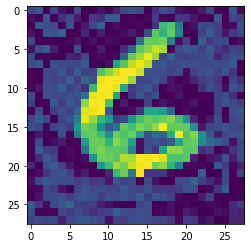

In [65]:
adv_jpg = to_jpg_and_back(adv)
plt.imshow(adv_jpg[0])

print('classifier prediction: ', classifier.predict_by_image(adv_jpg, autoencoder))